In [2]:
import pandas as pd
import json
import itertools
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from collections import defaultdict
from math import log
from sklearn.model_selection import train_test_split, GridSearchCV,learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import seaborn as sns
import time
from sklearn.calibration import CalibratedClassifierCV

In [5]:
with open(r'C:\Users\ierop\kursach\data\group1.json', 'r') as f:
    data = json.load(f)
df = pd.DataFrame(data)
df

,id,city,can_write_private_message,can_send_friend_request,followers_count,sex,friends,subscriptions,bdate,career,university,faculty,schools,position,class,year_from
0,615138,1.0,0,1.0,652.0,2.0,"[15113, 28177, 128986, 259969, 308603, 550516,...","[31480508, 58533920, 27794994, 59054401, 84875...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6829824,59.0,1,1.0,2475.0,1.0,"[391978, 795474, 948971, 1083426, 1420855, 170...","[176431013, 36018360, 28658784, 138392500, 648...",6.12.1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7246627,59.0,1,1.0,238.0,2.0,"[1671032, 3108469, 4601469, 5932396, 6662079, ...","[59054401, 149640858, 25554967, 31836774, 4472...",NaN,45608667,0.0,0.0,76795,,б,2009
3,22926334,59.0,0,1.0,629.0,2.0,"[5574930, 5871064, 6727178, 7641089, 7974750, ...","[178151382, 138140232, 138392500, 164291318, 1...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,22927976,NaN,0,1.0,385.0,2.0,"[3335062, 4627055, 8646144, 9284689, 9905360, ...","[15856743, 118675075, 28477986, 28261265, 7682...",2.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,632626273,NaN,1,1.0,NaN,2.0,[],[],7.2.1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122,642847496,NaN,1,1.0,342.0,1.0,"[465642, 729392, 968817, 2098307, 2440008, 249...","[138319812, 113133652, 46509740, 65956102, 126...",21.2.2000,[],0.0,0.0,[],NaN,NaN,NaN
123,649379678,NaN,1,1.0,NaN,1.0,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124,711634990,NaN,0,0.0,NaN,2.0,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
def sample_dfs(filenames):
    true_list = []
    false_list = []
    for filename in filenames:
        with open(filename, 'r') as f:
            data = json.load(f)

        df = pd.DataFrame(data)
    
        pattern = r'^\d{1,2}\.\d{1,2}\.\d{4}$'
        df['bdate'] = df['bdate'].where(df['bdate'].str.match(pattern)) # NaN там, где дата не корректна

        df['friends_count']=df.friends.str.len() # Отдельный столбец для количества друзей
        
        city_mode = df['city'].mode()[0]
        df['city'].fillna(city_mode, inplace=True)

        # Создаем пары пользователей
        all_users = df['id'].tolist()
        pairs = list(itertools.combinations(all_users, 2))  # создаем комбинации по два пользователя без повторений

        # Создаем новый DataFrame для хранения результатов
        pairs_df = pd.DataFrame(pairs, columns=['user_1', 'user_2'])

        # Расширяем pairs_df, подтягивая информацию для каждого пользователя
        pairs_df = pairs_df.merge(df.add_suffix('_1'), left_on='user_1', right_on='id_1')
        pairs_df = pairs_df.merge(df.add_suffix('_2'), left_on='user_2', right_on='id_2')
        pairs_df.drop(columns=['id_1','id_2'],inplace=True)

        # Функция для проверки, являются ли пользователи друзьями
        def are_friends(row):
            friends_1 = row['friends_1']
            friends_2 = row['friends_2']
            user_1 = row['user_1']
            user_2 = row['user_2']
            return str(user_2) in friends_1 and str(user_1) in friends_2

        # Применяем функцию проверки дружбы
        pairs_df['are_friends'] = pairs_df.apply(are_friends, axis=1)

        cols_to_check = pairs_df.columns
        for col in cols_to_check:
            pairs_df[col] = pairs_df[col].apply(lambda x: np.nan if isinstance(x, list) and len(x) == 0 else x) # если ячейка содержит пустой список - заменяем на NaN
        # Добавляем все записи с файла где пара пользователей - друзья
        true_list.append(pairs_df[pairs_df['are_friends']==True]) 
        # Добавляем записи с файла где пара пользователей - не друзья, количество записей - количество друзей в файле
        false_list.append(pairs_df[pairs_df['are_friends']==False].sample(pairs_df[pairs_df['are_friends']==True].shape[0])) 
    
    # объединяем всю информацию с нескольких групп
    group1_df = pd.concat(true_list, ignore_index=True)
    group2_df = pd.concat(false_list, ignore_index=True)
    final_data=pd.concat([group1_df,group2_df])
    return final_data

In [17]:
filenames=[r'C:\Users\ierop\kursach\data\group1.json',r'C:\Users\ierop\kursach\data\group2.json',r'C:\Users\ierop\kursach\data\group3.json',r'C:\Users\ierop\kursach\data\group4.json',r'C:\Users\ierop\kursach\data\group5.json']
data=sample_dfs(filenames)
data.head(5)

,user_1,user_2,city_1,can_write_private_message_1,can_send_friend_request_1,followers_count_1,sex_1,friends_1,subscriptions_1,bdate_1,...,bdate_2,career_2,university_2,faculty_2,schools_2,position_2,class_2,year_from_2,friends_count_2,are_friends
0,22926334,22927976,59.0,0,1.0,629.0,2.0,"[5574930, 5871064, 6727178, 7641089, 7974750, ...","[178151382, 138140232, 138392500, 164291318, 1...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,316,True
1,22926334,25136612,59.0,0,1.0,629.0,2.0,"[5574930, 5871064, 6727178, 7641089, 7974750, ...","[178151382, 138140232, 138392500, 164291318, 1...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,191,True
2,22927976,25136612,59.0,0,1.0,385.0,2.0,"[3335062, 4627055, 8646144, 9284689, 9905360, ...","[15856743, 118675075, 28477986, 28261265, 7682...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,191,True
3,22926334,33127501,59.0,0,1.0,629.0,2.0,"[5574930, 5871064, 6727178, 7641089, 7974750, ...","[178151382, 138140232, 138392500, 164291318, 1...",NaN,...,19.7.1989,NaN,0.0,0.0,32018,NaN,,2005,252,True
4,22927976,33127501,59.0,0,1.0,385.0,2.0,"[3335062, 4627055, 8646144, 9284689, 9905360, ...","[15856743, 118675075, 28477986, 28261265, 7682...",NaN,...,19.7.1989,NaN,0.0,0.0,32018,NaN,,2005,252,True


In [38]:
data.shape

(31554, 22)

In [39]:
data.describe()

,user_1,user_2,city_1,can_write_private_message_1,can_send_friend_request_1,followers_count_1,sex_1,friends_count_1,city_2,can_write_private_message_2,can_send_friend_request_2,followers_count_2,sex_2,friends_count_2,jaccard,overlap,aa_index
count,3.155400e+04,3.155400e+04,3.155400e+04,31554.000000,31554.000000,31554.000000,31554.000000,31554.000000,3.155400e+04,31554.000000,31554.000000,31554.000000,31554.000000,31554.000000,31554.000000,31554.000000,31554.000000
mean,3.005192e+08,4.266759e+08,5.305981e+04,0.724599,0.993852,377.344915,1.466597,200.578342,5.483761e+04,0.750143,0.977404,319.878219,1.479242,184.994581,0.024777,0.069153,1.675027
std,1.625958e+08,1.770432e+08,4.022941e+05,0.446723,0.378016,675.872807,0.621030,273.992993,3.975202e+05,0.432937,0.363836,453.877860,0.599890,252.080875,0.035367,0.093157,2.620057
min,6.151380e+05,1.846220e+07,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.615014e+08,2.763881e+08,1.000000e+00,0.000000,1.000000,214.000000,1.000000,59.000000,1.000000e+00,1.000000,1.000000,170.000000,1.000000,41.000000,0.000000,0.000000,0.000000
50%,2.974587e+08,4.327927e+08,1.000000e+00,1.000000,1.000000,351.000000,2.000000,163.000000,1.000000e+00,1.000000,1.000000,299.000000,2.000000,142.000000,0.007299,0.025000,0.477224
75%,4.221785e+08,5.674935e+08,1.000000e+00,1.000000,1.000000,391.000000,2.000000,269.000000,1.000000e+00,1.000000,1.000000,345.000000,2.000000,249.000000,0.039492,0.114403,2.626440
max,7.822123e+08,8.529717e+08,5.470540e+06,1.000000,2.000000,21008.000000,2.000000,5000.000000,5.470540e+06,1.000000,2.000000,21008.000000,2.000000,5000.000000,0.505618,1.000000,83.965823


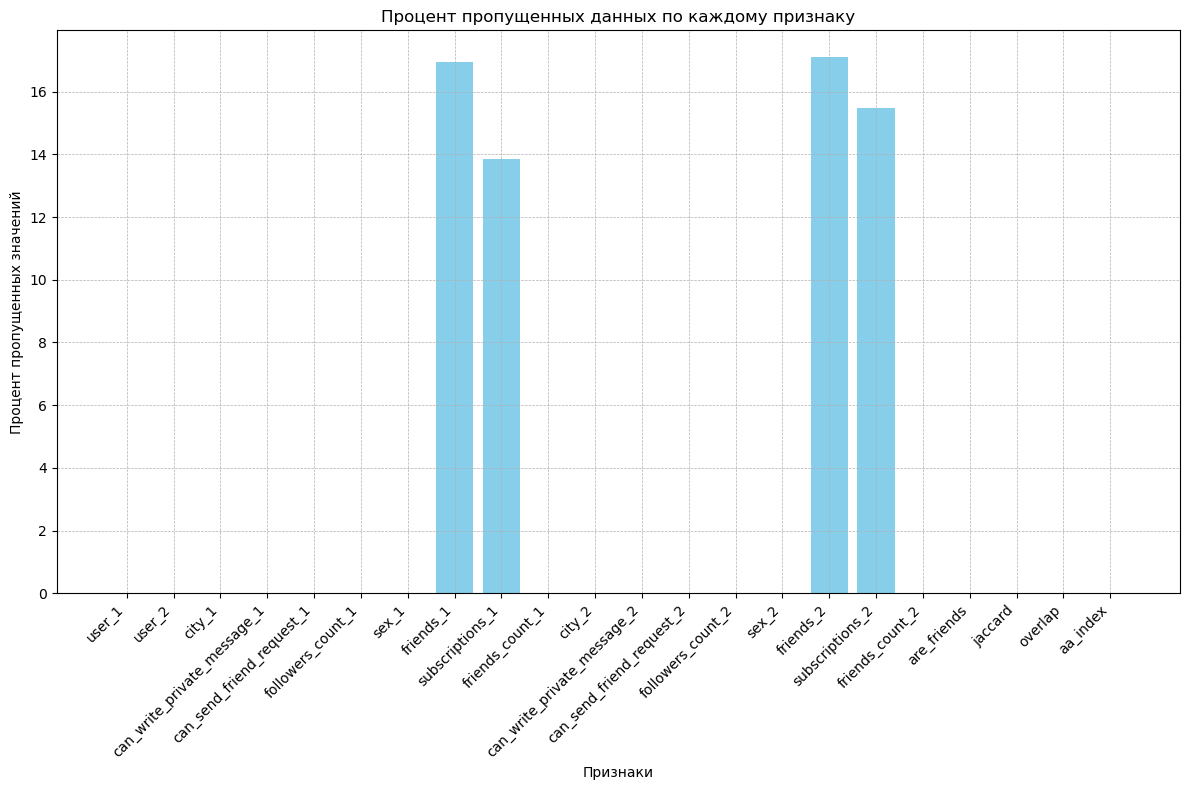

In [40]:
# Возьмем столбцы DataFrame как признаки
feature_columns = data.columns.tolist()

# Рассчитываем процент пропущенных значений для каждого признака
missing_percent = {}
for col in feature_columns:
    missing_percent[col] = data[col].isnull().mean() * 100

# Создание гистограммы
plt.figure(figsize=(12, 8))
plt.bar(missing_percent.keys(), missing_percent.values(), color='skyblue')
plt.title('Процент пропущенных данных по каждому признаку')
plt.xlabel('Признаки')
plt.ylabel('Процент пропущенных значений')
plt.xticks(rotation=45, ha='right', fontsize=10)  # Настройка угла и горизонтального выравнивания
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [41]:
for key,value in missing_percent.items():
    print(f'Процент пропущенных значений у признака {key}: {value}')

Процент пропущенных значений у признака user_1: 0.0
Процент пропущенных значений у признака user_2: 0.0
Процент пропущенных значений у признака city_1: 0.0
Процент пропущенных значений у признака can_write_private_message_1: 0.0
Процент пропущенных значений у признака can_send_friend_request_1: 0.0
Процент пропущенных значений у признака followers_count_1: 0.0
Процент пропущенных значений у признака sex_1: 0.0
Процент пропущенных значений у признака friends_1: 16.93287697280852
Процент пропущенных значений у признака subscriptions_1: 13.865120111554797
Процент пропущенных значений у признака friends_count_1: 0.0
Процент пропущенных значений у признака city_2: 0.0
Процент пропущенных значений у признака can_write_private_message_2: 0.0
Процент пропущенных значений у признака can_send_friend_request_2: 0.0
Процент пропущенных значений у признака followers_count_2: 0.0
Процент пропущенных значений у признака sex_2: 0.0
Процент пропущенных значений у признака friends_2: 17.10084299930278
П

In [42]:
data.drop(columns=['bdate_1','career_1','university_1','faculty_1','schools_1','position_1','class_1','year_from_1','bdate_2','career_2','university_2','faculty_2','schools_2','position_2','class_2','year_from_2'],inplace=True)

KeyError: "['bdate_1', 'career_1', 'university_1', 'faculty_1', 'schools_1', 'position_1', 'class_1', 'year_from_1', 'bdate_2', 'career_2', 'university_2', 'faculty_2', 'schools_2', 'position_2', 'class_2', 'year_from_2'] not found in axis"

In [ ]:
data['are_friends'].value_counts()

True     15777
False    15777
Name: are_friends, dtype: int64

In [ ]:
followers_mean = data['followers_count_1'].mean()
data['followers_count_1'].fillna(followers_mean, inplace=True)

followers_mean = data['followers_count_2'].mean()
data['followers_count_2'].fillna(followers_mean, inplace=True)

In [ ]:
data['sex_1'].fillna(0, inplace=True)
data['sex_2'].fillna(0, inplace=True)

In [ ]:
data['can_send_friend_request_1'].fillna(2, inplace=True)
data['can_send_friend_request_2'].fillna(2, inplace=True)

In [ ]:
data.isna().sum()

user_1                            0
user_2                            0
city_1                            0
can_write_private_message_1       0
can_send_friend_request_1         0
followers_count_1                 0
sex_1                             0
friends_1                      5343
subscriptions_1                4375
friends_count_1                   0
city_2                            0
can_write_private_message_2       0
can_send_friend_request_2         0
followers_count_2                 0
sex_2                             0
friends_2                      5396
subscriptions_2                4886
friends_count_2                   0
are_friends                       0
dtype: int64

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31554 entries, 0 to 15776
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   user_1                       31554 non-null  int64  
 1   user_2                       31554 non-null  int64  
 2   city_1                       31554 non-null  float64
 3   can_write_private_message_1  31554 non-null  int64  
 4   can_send_friend_request_1    31554 non-null  float64
 5   followers_count_1            31554 non-null  float64
 6   sex_1                        31554 non-null  float64
 7   friends_1                    26211 non-null  object 
 8   subscriptions_1              27179 non-null  object 
 9   friends_count_1              31554 non-null  int64  
 10  city_2                       31554 non-null  float64
 11  can_write_private_message_2  31554 non-null  int64  
 12  can_send_friend_request_2    31554 non-null  float64
 13  followers_count_

In [44]:
# Функции для расчета метрик
def jaccard_index(set1, set2,set3,set4):
    if not(isinstance(set1, list)):
        set1=[]
    if not(isinstance(set2, list)):
        set2=[]
    if not(isinstance(set3, list)):
        set3=[]
    if not(isinstance(set4, list)):
        set4=[]
    set_1=set(set1)|set(set2)
    set_2=set(set3)|set(set4)

    if len(set_1)==0 and len(set_2)==0:
        return 0  #если оба множества пусты
    

    intersection = len(set_1 & set_2)
    union = len(set_1 | set_2)
    return intersection / union

def overlap_coefficient(set1, set2,set3,set4):
    if not(isinstance(set1, list)):
        set1=[]
    if not(isinstance(set2, list)):
        set2=[]
    if not(isinstance(set3, list)):
        set3=[]
    if not(isinstance(set4, list)):
        set4=[]
    set_1=set(set1)|set(set2)
    set_2=set(set3)|set(set4)

    if len(set_1)==0 or len(set_2)==0:
        return 0  # если одно из множеств пусто
    
    intersection = len(set_1 & set_2)
    return intersection / min(len(set_1), len(set_2))

In [45]:
data['jaccard'] = data.apply(lambda x: jaccard_index(x['friends_1'],x['subscriptions_1'], x['friends_2'],x['subscriptions_2']), axis=1)
data['overlap'] = data.apply(lambda x: overlap_coefficient(x['friends_1'],x['subscriptions_1'], x['friends_2'],x['subscriptions_2']), axis=1)

In [46]:
def adamic_adar_index(friends_1, friends_2, subscriptions_1, subscriptions_2, freq_dict):
    # Объединяем друзей и подписки каждого пользователя
    if not(isinstance(friends_1, list)):
        friends_1=[]
    if not(isinstance(friends_2, list)):
        friends_2=[]
    if not(isinstance(subscriptions_1, list)):
        subscriptions_1=[]
    if not(isinstance(subscriptions_2, list)):
        subscriptions_2=[]

    nodes_1 = set(friends_1 + subscriptions_1)
    nodes_2 = set(friends_2 + subscriptions_2)
    # Нахождение общих узлов
    common_nodes = nodes_1.intersection(nodes_2)
    
    # Расчет Adamic-Adar индекса с учетом взвешивания по частотам
    index = 0
    for node in common_nodes:
        # Защита от деления на ноль, если узел встречается в freq_dict редко (т.е. log(freq_dict[node]) приводит к бесконечности)
        if freq_dict[node] > 1:
            index += 1 / log(freq_dict[node])
    
    return index


# Создание частотного словаря для узлов (для оптимизации расчета)
def create_freq_dict(df):
    freq_dict = defaultdict(int)
    # Итерация по строкам DataFrame для подсчета частоты каждого узла
    for index, row in df.iterrows():
        set1,set2,set3,set4=row['friends_1'], row['friends_2'], row['subscriptions_1'], row['subscriptions_2']
        if not(isinstance(set1, list)):
            set1=[]
        if not(isinstance(set2, list)):
            set2=[]
        if not(isinstance(set3, list)):
            set3=[]
        if not(isinstance(set4, list)):
            set4=[]
        for node in set1 + set2 + set3 + set4:
            freq_dict[node] += 1
    return freq_dict

freq_dict = create_freq_dict(data)

In [47]:
data['aa_index'] = data.apply(lambda x: adamic_adar_index(x['friends_1'], x['friends_2'],x['subscriptions_1'],x['subscriptions_2'], freq_dict), axis=1)

In [48]:
def preferential_attachment(friends_1, friends_2, subscriptions_1, subscriptions_2):
    if not(isinstance(friends_1, list)):
        friends_1=[]
    if not(isinstance(friends_2, list)):
        friends_2=[]
    if not(isinstance(subscriptions_1, list)):
        subscriptions_1=[]
    if not(isinstance(subscriptions_2, list)):
        subscriptions_2=[]
    # Вычислить количество связей для первого пользователя
    connections_1 = len(set(friends_1).union(subscriptions_1))
    
    # Вычислить количество связей для второго пользователя
    connections_2 = len(set(friends_2).union(subscriptions_2))
    
    # Мера Preferential Attachment - это произведение количества связей двух пользователей
    return connections_1 * connections_2


data['pref_at'] = data.apply(lambda x: preferential_attachment(x['friends_1'], x['friends_2'],x['subscriptions_1'],x['subscriptions_2']), axis=1)

In [49]:
G = nx.Graph()

# Добавление пользователей и их связей в граф с проверкой на пустые значения
for index, row in data.iterrows():
    user1 = row['user_1']
    user2 = row['user_2']

    friends_1 = row['friends_1'] if isinstance(row['friends_1'], list) else []
    friends_2 = row['friends_2'] if isinstance(row['friends_2'], list) else []
    subs_1 = row['subscriptions_1'] if isinstance(row['subscriptions_1'], list) else []
    subs_2 = row['subscriptions_2'] if isinstance(row['subscriptions_2'], list) else []
    k=0
    for friend in friends_1:
        G.add_edge(user1, friend)
        k+=1
        if k>10:
            break
    k=0
    for friend in friends_2:
        G.add_edge(user2, friend)
        k+=1
        if k>10:
            break
    k=0 
    for sub in subs_1:
        G.add_edge(user1, sub)
        k+=1
        if k>10:
            break
    k=0  
    for sub in subs_2:
        G.add_edge(user2, sub)
        k+=1
        if k>10:
            break
        
    # Связи между двумя пользователями
    G.add_edge(user1, user2)

In [23]:
def find_optimal_alpha(graph):
    # Рассчитываем собственные значения лапласиана графа
    eigenvalues = nx.laplacian_spectrum(graph)
    # Берем максимальное собственное значение
    max_eigenvalue = max(eigenvalues)
    # Вычисляем оптимальное alpha как значение меньше обратного к максимальному собственному значению
    optimal_alpha = 1 / max_eigenvalue * 0.9  # берем 90% от максимального возможного значения для надежности
    return optimal_alpha
optimal_alpha = find_optimal_alpha(G)

<class 'networkx.utils.decorators.argmap'> compilation 4:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [50]:
optimal_alpha = 0.0031883829041098044

In [51]:
katz_centrality = nx.katz_centrality_numpy(G, alpha=optimal_alpha,beta=1)

c:\Users\ierop\anaconda3\lib\site-packages\networkx\algorithms\centrality\katz.py:325: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=nodelist, weight=weight).todense().T


In [52]:
def get_katz_similarity(user1, user2, katz_centrality):
    # Возьмите centrality значения двух пользователей и посчитайте их близость
    similarity = katz_centrality.get(user1, 0) * katz_centrality.get(user2, 0)
    return similarity

In [53]:
data['katz_coef']=data.apply(lambda x: get_katz_similarity(x['user_1'], x['user_2'],katz_centrality), axis=1)

In [54]:
data['same_city'] = data['city_1'] == data['city_2']

In [55]:
data['are_friends'] = data['are_friends'].astype(int)
data['same_city'] = data['same_city'].astype(int)
data['same_sex']= (data['sex_1'] == data['sex_2']).astype(int)

In [56]:
data1=data.drop(columns=['friends_1','subscriptions_1','friends_2','subscriptions_2','user_1','user_2','city_1','city_2','sex_1','sex_2'])

In [57]:
data1.head(5)

,can_write_private_message_1,can_send_friend_request_1,followers_count_1,friends_count_1,can_write_private_message_2,can_send_friend_request_2,followers_count_2,friends_count_2,are_friends,jaccard,overlap,aa_index,pref_at,katz_coef,same_city,same_sex
0,0,1.0,629.0,457,0,1.0,385.0,316,1,0.120166,0.260479,15.914157,159318,0.000041,1,1
1,0,1.0,629.0,457,1,1.0,473.0,191,1,0.100800,0.298578,11.316591,100647,0.000042,1,1
2,0,1.0,385.0,316,1,1.0,473.0,191,1,0.149789,0.336493,12.967156,70474,0.000041,1,1
3,0,1.0,629.0,457,1,1.0,329.0,252,1,0.110448,0.277154,13.710771,127359,0.000041,1,1
4,0,1.0,385.0,316,1,1.0,329.0,252,1,0.104779,0.213483,10.441207,89178,0.000040,1,1


In [58]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31554 entries, 0 to 15776
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   can_write_private_message_1  31554 non-null  int64  
 1   can_send_friend_request_1    31554 non-null  float64
 2   followers_count_1            31554 non-null  float64
 3   friends_count_1              31554 non-null  int64  
 4   can_write_private_message_2  31554 non-null  int64  
 5   can_send_friend_request_2    31554 non-null  float64
 6   followers_count_2            31554 non-null  float64
 7   friends_count_2              31554 non-null  int64  
 8   are_friends                  31554 non-null  int32  
 9   jaccard                      31554 non-null  float64
 10  overlap                      31554 non-null  float64
 11  aa_index                     31554 non-null  float64
 12  pref_at                      31554 non-null  int64  
 13  katz_coef       

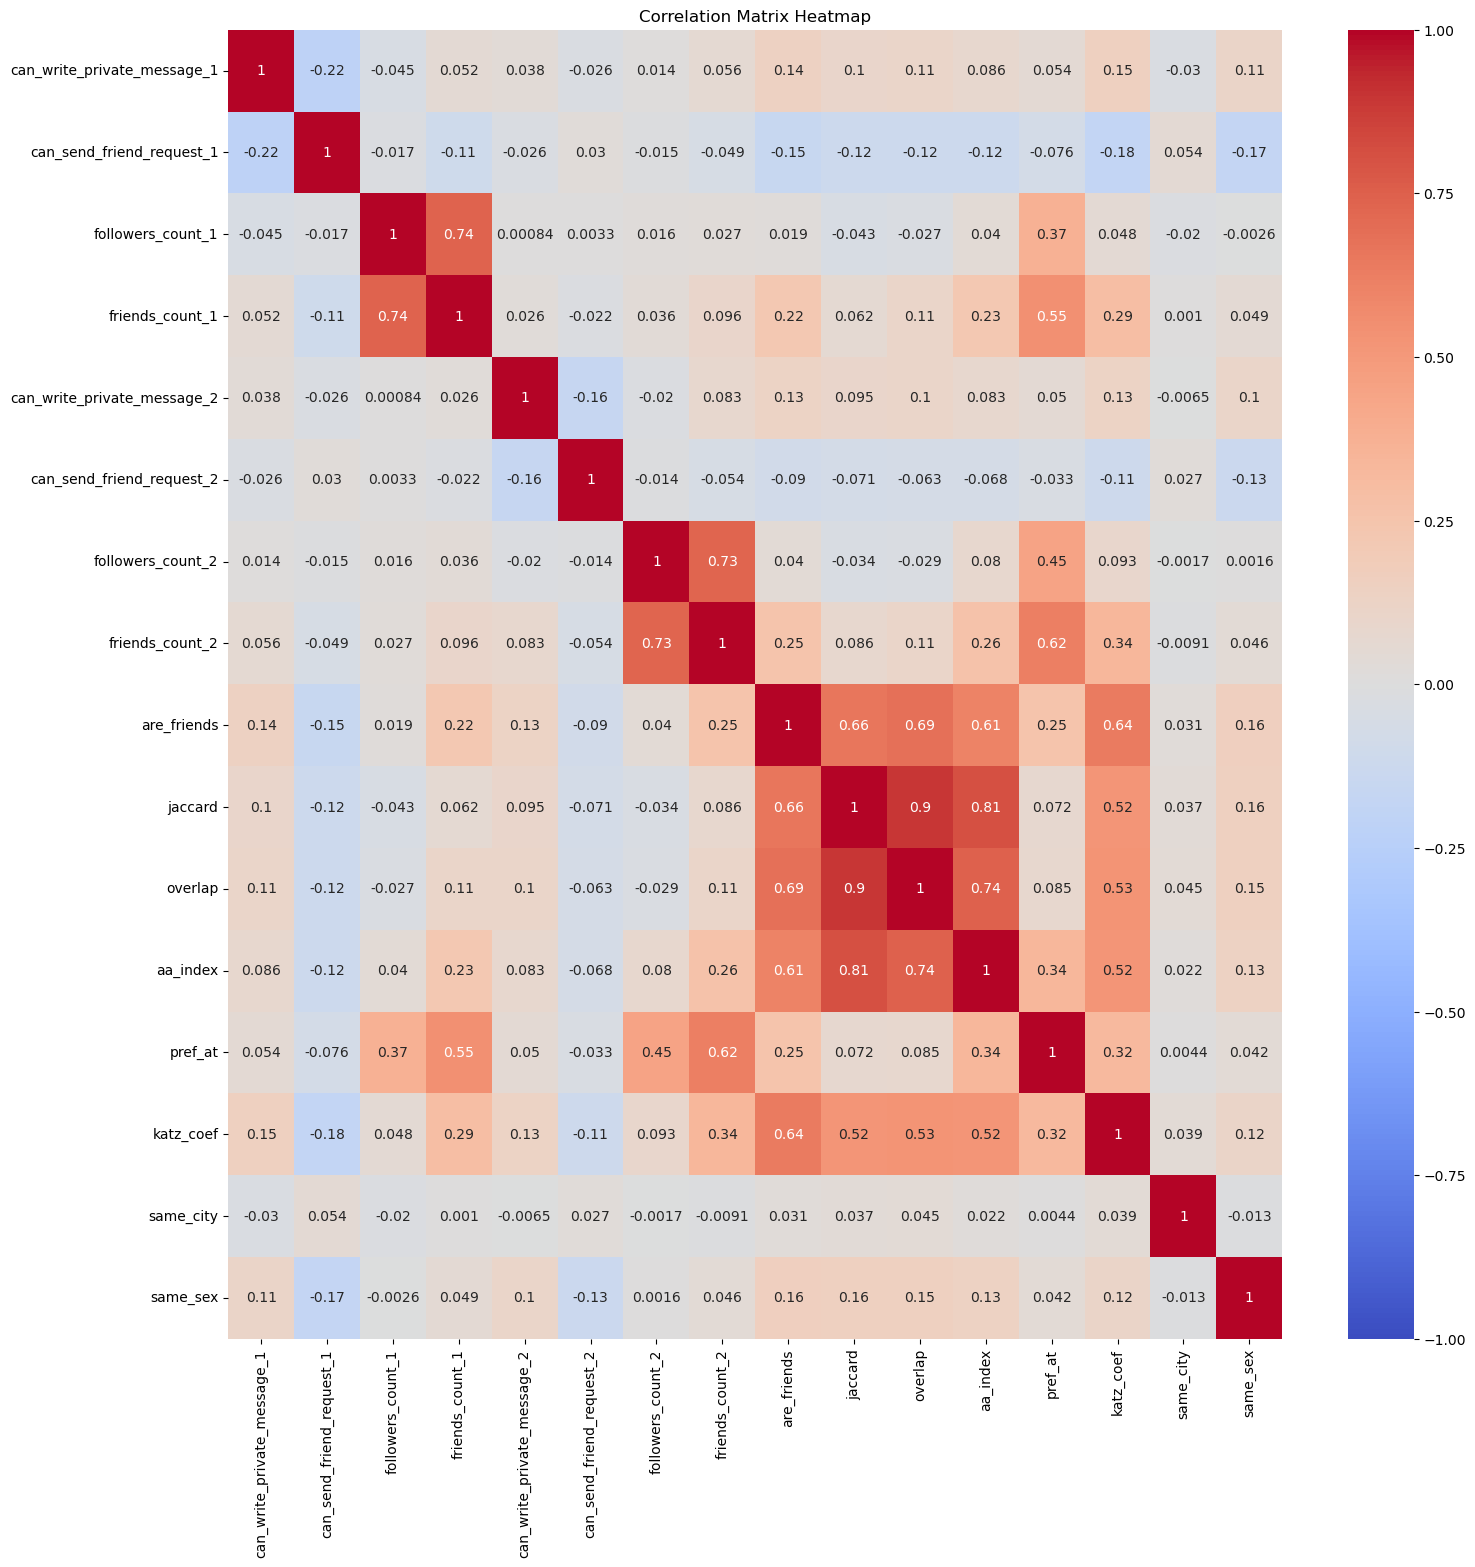

In [113]:
corr_matrix = data1.corr()
# Визуализация корреляционной матрицы
plt.figure(figsize=(17, 17)) # устанавливаем размер фигуры
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

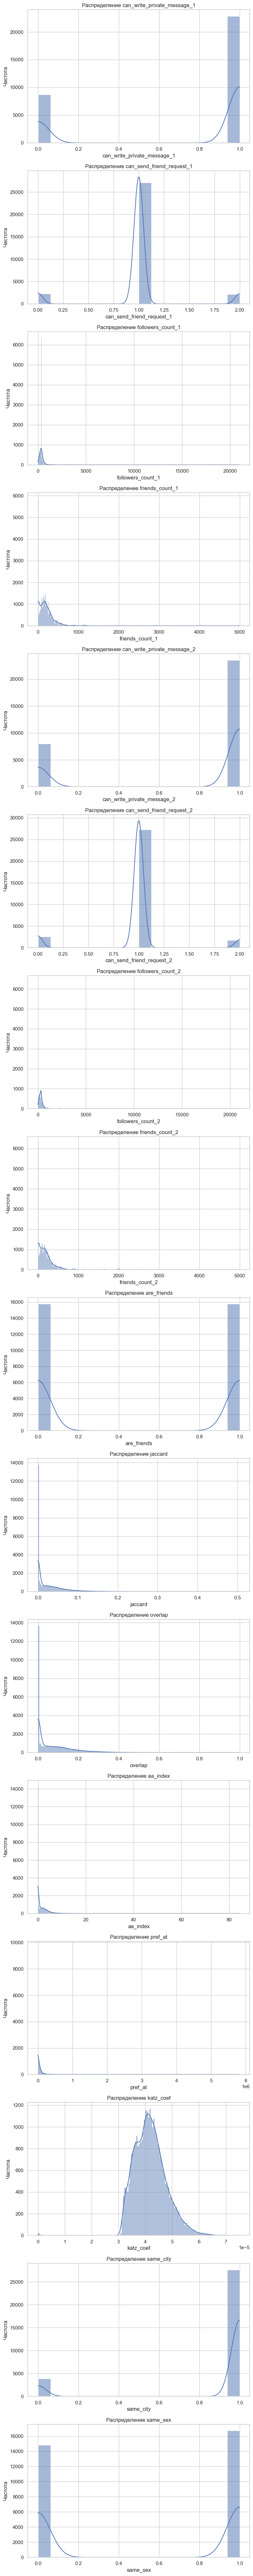

In [114]:
sns.set_theme(style='whitegrid')
# Создаем фигуру и оси для графиков Matplotlib
fig, axes = plt.subplots(nrows=len(data1.columns), figsize=(8, 5 * len(data1.columns)))

# Визуализируем распределение для каждого столбца
for ax, column in zip(axes, data1.columns):
    sns.histplot(data1[column], kde=True, ax=ax)  # КDE=True добавляет линию плотности размытия
    ax.set_title(f'Распределение {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Частота')

# Подгоняем layout и показываем график
plt.tight_layout()
plt.show()


In [59]:
data1.reset_index(drop=True, inplace=True)

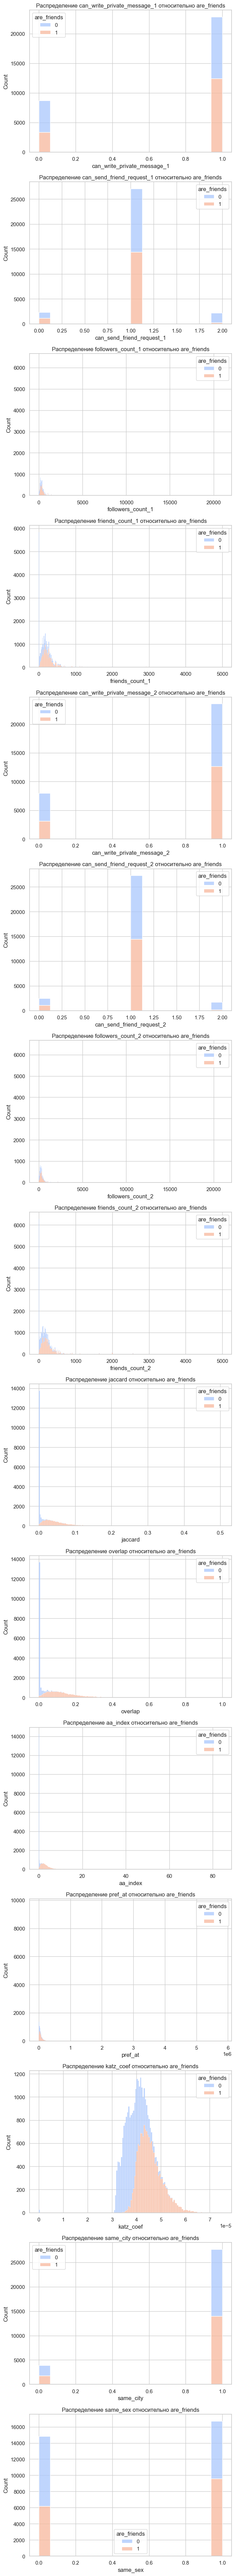

In [120]:
features = data1.columns.drop('are_friends')

sns.set_theme(style='whitegrid')
fig, axes = plt.subplots(nrows=len(features), figsize=(7, 5 * len(features)))

for i, feature in enumerate(features):
    sns.histplot(data=data1, x=feature, hue='are_friends', multiple="stack", ax=axes[i], palette='coolwarm')
    axes[i].set_title(f'Распределение {feature} относительно are_friends')

plt.tight_layout()
plt.show()

In [60]:
data1.drop(columns=['same_city','followers_count_1','followers_count_2'],inplace=True)

In [61]:
data1.head()

,can_write_private_message_1,can_send_friend_request_1,friends_count_1,can_write_private_message_2,can_send_friend_request_2,friends_count_2,are_friends,jaccard,overlap,aa_index,pref_at,katz_coef,same_sex
0,0,1.0,457,0,1.0,316,1,0.120166,0.260479,15.914157,159318,0.000041,1
1,0,1.0,457,1,1.0,191,1,0.100800,0.298578,11.316591,100647,0.000042,1
2,0,1.0,316,1,1.0,191,1,0.149789,0.336493,12.967156,70474,0.000041,1
3,0,1.0,457,1,1.0,252,1,0.110448,0.277154,13.710771,127359,0.000041,1
4,0,1.0,316,1,1.0,252,1,0.104779,0.213483,10.441207,89178,0.000040,1


In [62]:
X = data1.drop('are_friends', axis=1)
y = data1['are_friends']

In [63]:
models = [
    ('LogisticRegression', LogisticRegression()),
    ('SVC', SVC(probability=True)),
    ('RandomForest', RandomForestClassifier()),
    ('GradientBoosting', GradientBoostingClassifier()),
    ('Perceptron', Perceptron()),
    ('DecisionTree', DecisionTreeClassifier()),
    ('KNeighbors', KNeighborsClassifier()),
    ('MLPClassifier', MLPClassifier(max_iter=1000)),
    ('XGBClassifier', xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)),
    ('LGBMClassifier', lgb.LGBMClassifier(objective='binary'))
]

results = []
roc_curves = []

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [65]:
for name, model in models:
    start_time = time.time()
    model.fit(X_train_scaled, y_train)
    elapsed_time = time.time() - start_time

    y_pred = model.predict(X_test_scaled)
    y_probs = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test_scaled)
    y_probs = (y_probs - y_probs.min()) / (y_probs.max() - y_probs.min())  # нормализация для Perceptron

    # Расчет метрик
    roc_auc = roc_auc_score(y_test, y_probs)
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_curves.append((name, fpr, tpr, roc_auc))

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    results.append((name, elapsed_time, roc_auc, acc, f1, precision, recall))

[LightGBM] [Info] Number of positive: 12622, number of negative: 12621
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1800
[LightGBM] [Info] Number of data points in the train set: 25243, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500020 -> initscore=0.000079
[LightGBM] [Info] Start training from score 0.000079


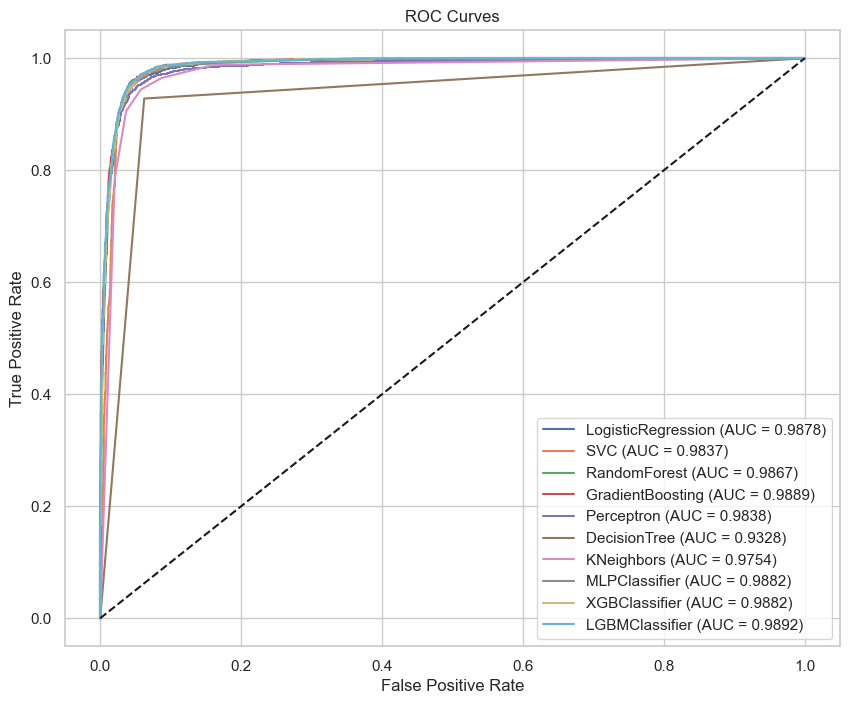

In [168]:
# Построение ROC-кривых
fig, ax = plt.subplots(figsize=(10, 8))
for name, fpr, tpr, roc_auc in roc_curves:
    ax.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

ax.plot([0, 1], [0, 1], 'k--')
ax.set_title('ROC Curves')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc='lower right')
plt.show()

In [66]:
results_df= pd.DataFrame(results, columns=['Model_name', 'Elapsed Time', 'ROC AUC', 'Accuracy', 'F1 Score', 'Precision', 'Recall'])
results_df

,Model_name,Elapsed Time,ROC AUC,Accuracy,F1 Score,Precision,Recall
0,LogisticRegression,0.070169,0.988134,0.948027,0.947131,0.963595,0.931220
1,SVC,31.689926,0.985526,0.951196,0.951096,0.952911,0.949287
2,RandomForest,3.459733,0.986984,0.958802,0.958939,0.955619,0.962282
3,GradientBoosting,4.759978,0.989306,0.956901,0.957071,0.953159,0.961014
4,Perceptron,0.022999,0.981430,0.937411,0.936931,0.944015,0.929952
5,DecisionTree,0.198998,0.934083,0.934083,0.933800,0.937680,0.929952
6,KNeighbors,0.084998,0.975814,0.942323,0.942350,0.941754,0.942948
7,MLPClassifier,21.084105,0.988944,0.955791,0.955833,0.954775,0.956894
8,XGBClassifier,0.359999,0.989121,0.957059,0.957343,0.950907,0.963867
9,LGBMClassifier,0.465666,0.989330,0.958485,0.958649,0.954731,0.962599


In [67]:
results_df['Mean Metric'] = results_df[['ROC AUC', 'Accuracy', 'F1 Score', 'Precision', 'Recall']].mean(axis=1)

In [68]:
best_average_model = results_df.loc[results_df['Mean Metric'].idxmax(), 'Model_name']
best_average_model

'LGBMClassifier'

In [69]:
metric_columns = ['ROC AUC', 'Accuracy', 'F1 Score', 'Precision', 'Recall']

for metric in metric_columns:
    best_model = results_df.loc[results_df[metric].idxmax(), 'Model_name']
    print(f"Лучшая модель для метрики {metric}: {best_model}")

Лучшая модель для метрики ROC AUC: LGBMClassifier
Лучшая модель для метрики Accuracy: RandomForest
Лучшая модель для метрики F1 Score: RandomForest
Лучшая модель для метрики Precision: LogisticRegression
Лучшая модель для метрики Recall: XGBClassifier


In [70]:
param_grid_lgb = {
    'num_leaves': [11,21,31, 51],
    'max_depth': [5,10, 20],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50,100, 200],
    'min_child_samples': [10, 20]
}

In [71]:
model_lgb=lgb.LGBMClassifier(objective='binary')

In [72]:
grid_lgb = GridSearchCV(model_lgb, param_grid_lgb, cv=5, scoring='roc_auc')
grid_lgb.fit(X_train_scaled, y_train)
print("Лучшие параметры для LGBMClassifier:", grid_lgb.best_params_)

[LightGBM] [Info] Number of positive: 10098, number of negative: 10096
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1800
[LightGBM] [Info] Number of data points in the train set: 20194, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500050 -> initscore=0.000198
[LightGBM] [Info] Start training from score 0.000198
[LightGBM] [Info] Number of positive: 10097, number of negative: 10097
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1801
[LightGBM] [Info] Number of data points in the train set: 20194, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 10097, number of negative: 1009

In [74]:
y_pred_lgb=grid_lgb.best_estimator_.predict(X_test_scaled)
y_proba_lgb=grid_lgb.best_estimator_.predict_proba(X_test_scaled)[:,1]

roc_auc = roc_auc_score(y_test, y_proba_lgb)
accuracy = accuracy_score(y_test, y_pred_lgb)
f1 = f1_score(y_test, y_pred_lgb)
precision = precision_score(y_test, y_pred_lgb)
recall = recall_score(y_test, y_pred_lgb)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

ROC AUC: 0.9899
Accuracy: 0.9582
F1 Score: 0.9583
Precision: 0.9547
Recall: 0.9620


[LightGBM] [Info] Number of positive: 990, number of negative: 1029
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1800
[LightGBM] [Info] Number of data points in the train set: 2019, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.490342 -> initscore=-0.038638
[LightGBM] [Info] Start training from score -0.038638
[LightGBM] [Info] Number of positive: 3261, number of negative: 3302
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1799
[LightGBM] [Info] Number of data points in the train set: 6563, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496876 -> initscore=-0.012494
[LightGBM] [Info] Start training from score -0.012494
[LightGBM] [Info] N

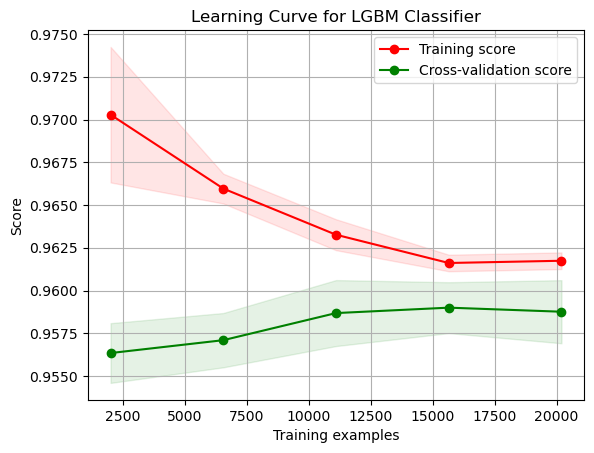

In [75]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
        
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Построение кривых обучения
plot_learning_curve(grid_lgb.best_estimator_, "Learning Curve for LGBM Classifier", X_train_scaled, y_train, cv=5)

plt.show()

In [76]:
y_pred_lgb=grid_lgb.best_estimator_.predict_proba(X_test_scaled)

In [77]:
calibrator = CalibratedClassifierCV(grid_lgb.best_estimator_, cv='prefit', method='sigmoid')
calibrator.fit(X_test_scaled, y_test)

calibrated_probabilities = calibrator.predict_proba(X_test_scaled)

In [78]:
print("Оригинальные вероятности [первые 5]:")
print(y_pred_lgb[:5])
print("\nКалиброванные вероятности [первые 5]:")
print(calibrated_probabilities[:5])

Оригинальные вероятности [первые 5]:
[[0.97873635 0.02126365]
 [0.00796168 0.99203832]
 [0.05149423 0.94850577]
 [0.12253686 0.87746314]
 [0.01947022 0.98052978]]

Калиброванные вероятности [первые 5]:
[[0.98108268 0.01891732]
 [0.02098184 0.97901816]
 [0.02949777 0.97050223]
 [0.0510133  0.9489867 ]
 [0.02296559 0.97703441]]
